In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns
import plotly.express as px

<h3>Preprocessing (Loading, removing and showing graphs)</h3>

In [3]:
from sklearn.preprocessing import LabelEncoder
data = pd.read_csv('/content/drive/MyDrive/Thesis/MalMem/Classification/balanced.csv')
lab=LabelEncoder()
data['Class']=lab.fit_transform(data['Class'])
data['Category']=lab.fit_transform(data['Category'])
#data['Family']=lab.fit_transform(data['Family'])
#data = data.drop(['Class'], axis=1)
#data = data.drop(['Category'], axis=1)
data = data.drop(['Family'], axis=1)
#columns with 0 values
data = data.drop(['pslist.nprocs64bit'], axis=1)
data = data.drop(['handles.nport'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool'], axis=1)
data = data.drop(['psxview.not_in_eprocess_pool_false_avg'], axis=1)
data = data.drop(['svcscan.interactive_process_services'], axis=1)
data = data.drop(['callbacks.nanonymous'], axis=1)
data = data.drop(['modules.nmodules'], axis=1)
data = data.drop(['callbacks.ngeneric'], axis=1)
data = data.drop(['svcscan.fs_drivers'], axis=1)

In [4]:
data = data.drop_duplicates()

In [5]:
import pandas as pd
from scipy import stats

# Define a threshold for z-score, typically 2 or 3
z_score_threshold = 3

# Function to remove outliers based on z-score for all columns
def remove_outliers_zscore_all_columns(data, threshold):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outliers = (abs_z_scores > threshold).all(axis=1)
    df_no_outliers = data[~outliers]
    return df_no_outliers

# Apply z-score outlier removal for all columns
df_no_outliers = remove_outliers_zscore_all_columns(data, z_score_threshold)
data = df_no_outliers

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

# Assuming your dataset is stored in a pandas DataFrame called 'df'

# Identify skewed features
skewness = data.apply(lambda x: skew(x))
skew_features = skewness[abs(skewness) > 0.5].index

# Apply log transformation to skewed features
#data[skew_features] = np.log1p(data[skew_features])

# Alternatively, you can use PowerTransformer for a more general approach
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
data[skew_features] = scaler.fit_transform(data[skew_features].values)

# Now, your dataset has reduced skewness


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


<h3>Normalization</h3>

In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Create a Min-Max scaler instance
scaler = StandardScaler()
# Select the columns you want to scale (exclude the target variable if needed)
columns_to_scale = data.columns  # You can select specific columns here

# Fit the scaler on the selected columns and transform the data
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

<h3>Spliting for Training and Testing</h3>

In [8]:
# Separate features and labels
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Class labels
X.shape

(38810, 47)

In [9]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Encode the target labels
smote = SMOTE(random_state=42)

X_smote, y_smote = smote.fit_resample(X, y_encoded)
X_smote.shape

(40016, 47)

<h3>LSTM with 20 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 20/20 [02:37<00:00,  7.85s/it]


Mean Accuracy: 72.03%
Mean Training Loss: 0.6356
Mean Test Loss: 0.6397
Mean Training Time (per epoch): 8296.08 seconds
Mean Testing Time (per epoch): 8296.08 seconds


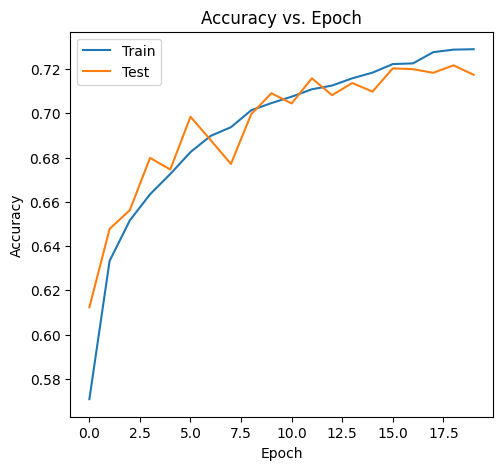

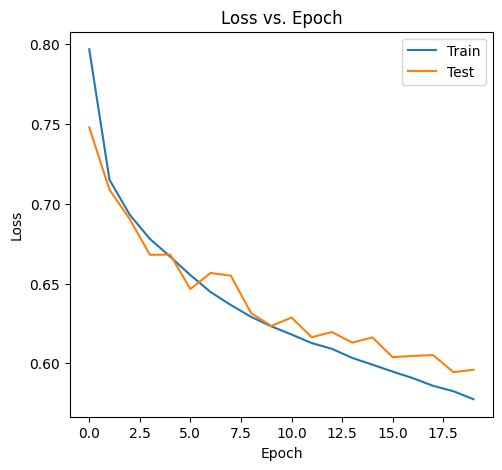

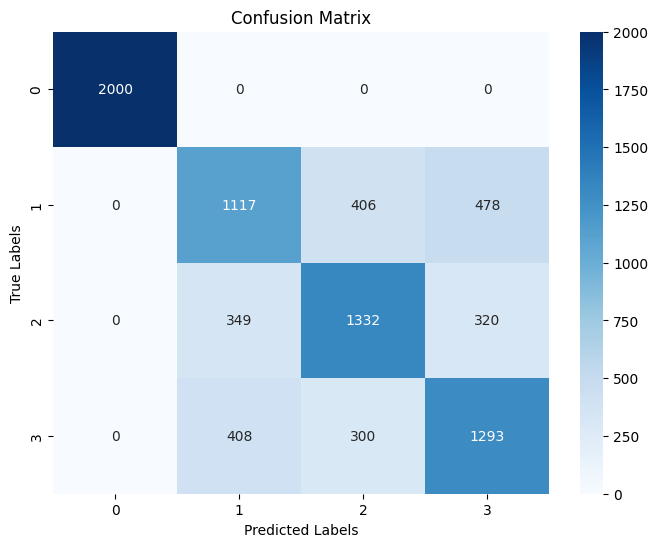

In [10]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define an LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
            self.fc = nn.Linear(lstm_hidden_size, num_classes)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out)
            return output

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    lstm_hidden_size = 128  # LSTM hidden layer size
    num_lstm_layers = 2  # Number of LSTM layers
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the LSTM model
    model = LSTMModel(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 20
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())


        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])

    # Calculate and display the confusion matrix
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)
# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Calculate and print the mean training and testing times
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/20_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/20_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/20_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

<h3>LSTM with 30 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 30/30 [03:45<00:00,  7.51s/it]


Mean Accuracy: 73.20%
Mean Training Loss: 0.6091
Mean Test Loss: 0.6203
Mean Training Time (per epoch): 18109.05 seconds
Mean Testing Time (per epoch): 18109.05 seconds


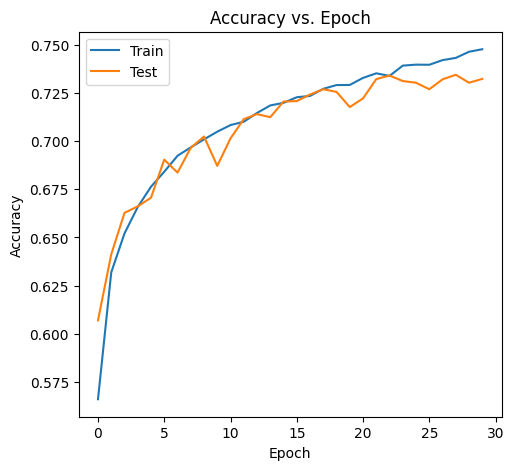

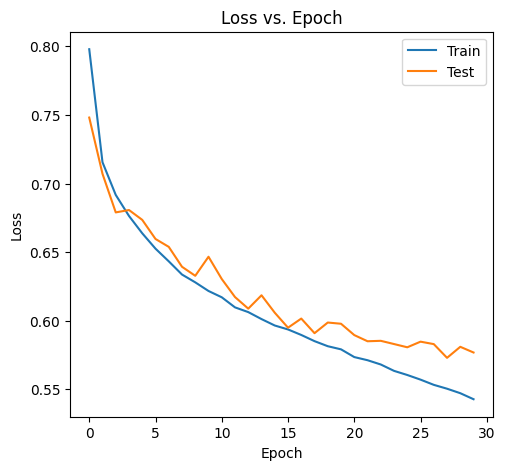

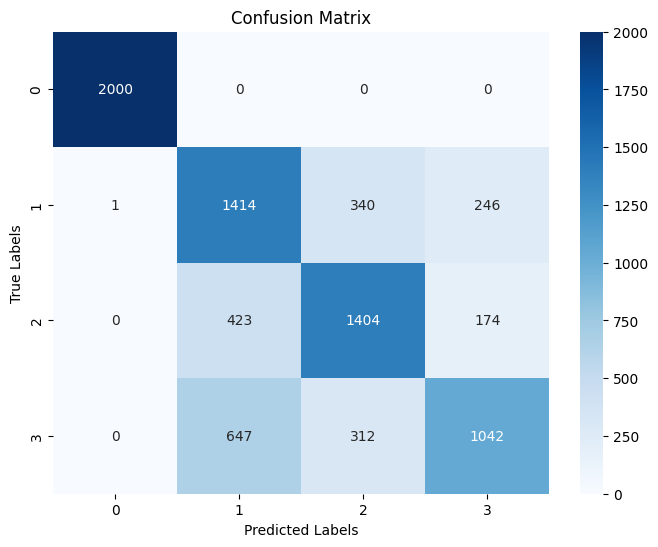

In [11]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define an LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
            self.fc = nn.Linear(lstm_hidden_size, num_classes)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out)
            return output

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    lstm_hidden_size = 128  # LSTM hidden layer size
    num_lstm_layers = 2  # Number of LSTM layers
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the LSTM model
    model = LSTMModel(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 30
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())


        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])

    # Calculate and display the confusion matrix
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)
# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Calculate and print the mean training and testing times
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/30_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/30_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/30_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

<h3>LSTM with 50 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 50/50 [06:27<00:00,  7.75s/it]


Mean Accuracy: 74.82%
Mean Training Loss: 0.5690
Mean Test Loss: 0.5994
Mean Training Time (per epoch): 48672.83 seconds
Mean Testing Time (per epoch): 48672.82 seconds


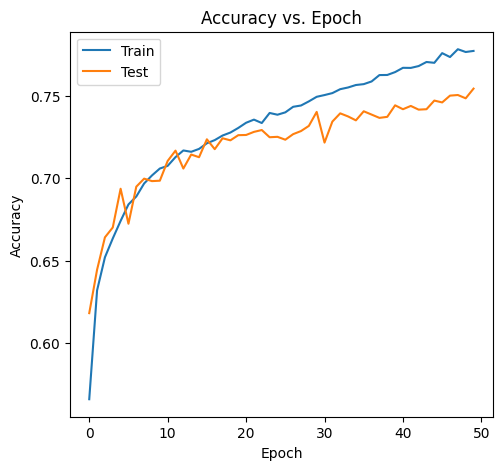

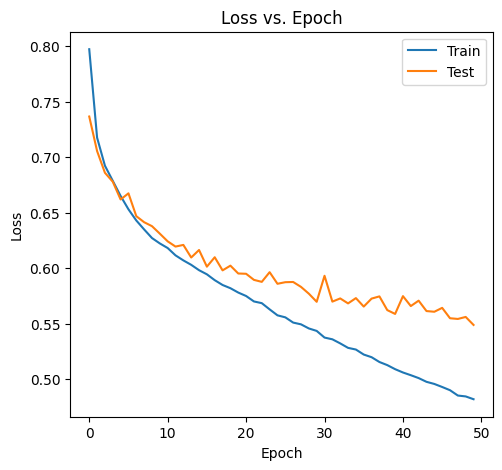

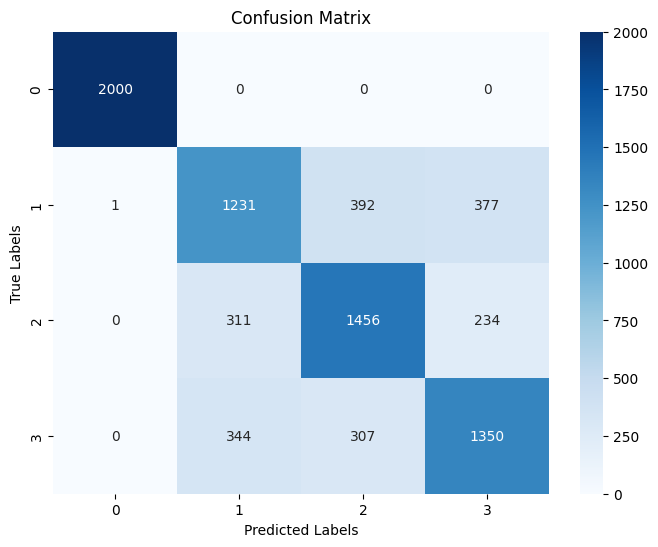

In [12]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define an LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
            self.fc = nn.Linear(lstm_hidden_size, num_classes)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out)
            return output

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    lstm_hidden_size = 128  # LSTM hidden layer size
    num_lstm_layers = 2  # Number of LSTM layers
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the LSTM model
    model = LSTMModel(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 50
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())


        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])

    # Calculate and display the confusion matrix
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)
# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Calculate and print the mean training and testing times
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/50_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/50_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/50_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

<h3>LSTM with 100 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 100/100 [12:53<00:00,  7.73s/it]


Mean Accuracy: 76.43%
Mean Training Loss: 0.5084
Mean Test Loss: 0.5725
Mean Training Time (per epoch): 196283.70 seconds
Mean Testing Time (per epoch): 196283.69 seconds


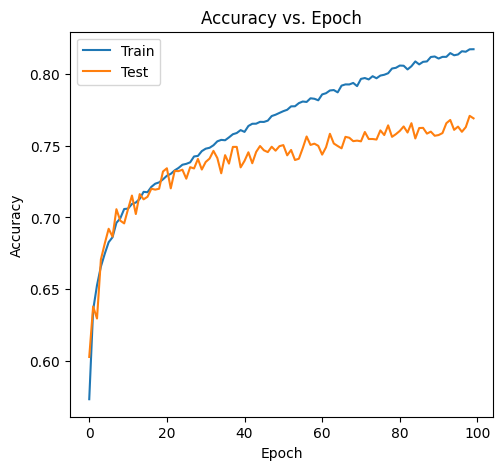

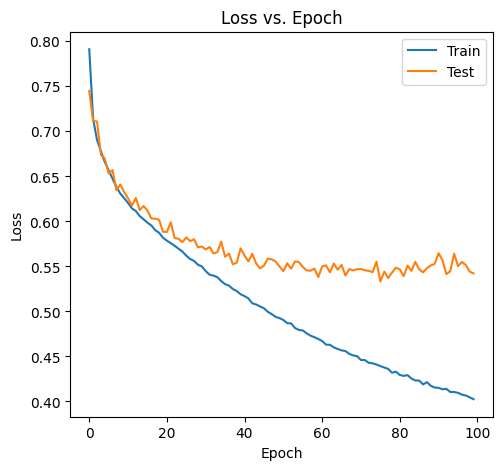

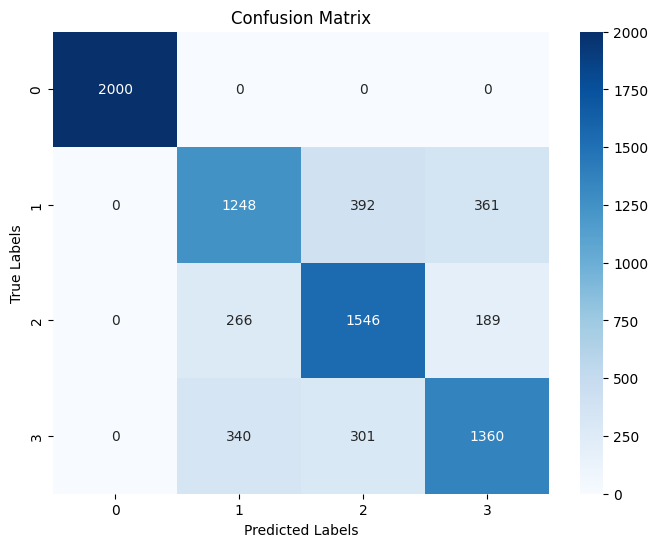

In [13]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define an LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
            self.fc = nn.Linear(lstm_hidden_size, num_classes)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out)
            return output

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    lstm_hidden_size = 128  # LSTM hidden layer size
    num_lstm_layers = 2  # Number of LSTM layers
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the LSTM model
    model = LSTMModel(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())


        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])

    # Calculate and display the confusion matrix
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)
# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Calculate and print the mean training and testing times
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/100_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/100_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/100_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure

<h3>LSTM with 150 Epochs Implementation</h3>

Fold 5/5: 100%|██████████| 150/150 [19:29<00:00,  7.79s/it]


Mean Accuracy: 77.02%
Mean Training Loss: 0.4635
Mean Test Loss: 0.5860
Mean Training Time (per epoch): 440670.99 seconds
Mean Testing Time (per epoch): 440670.97 seconds


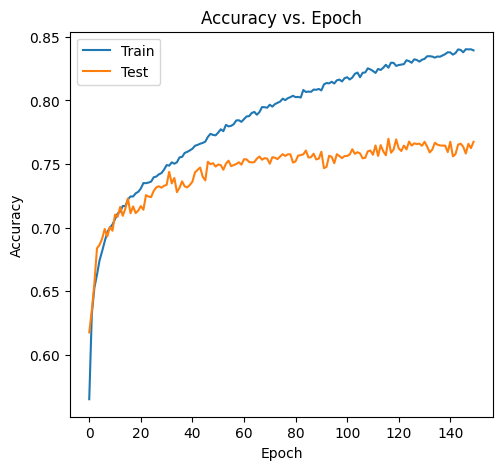

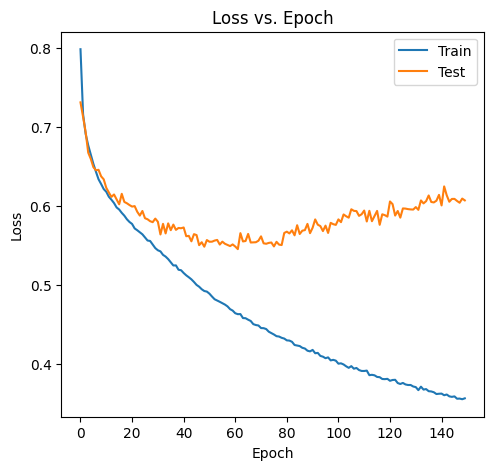

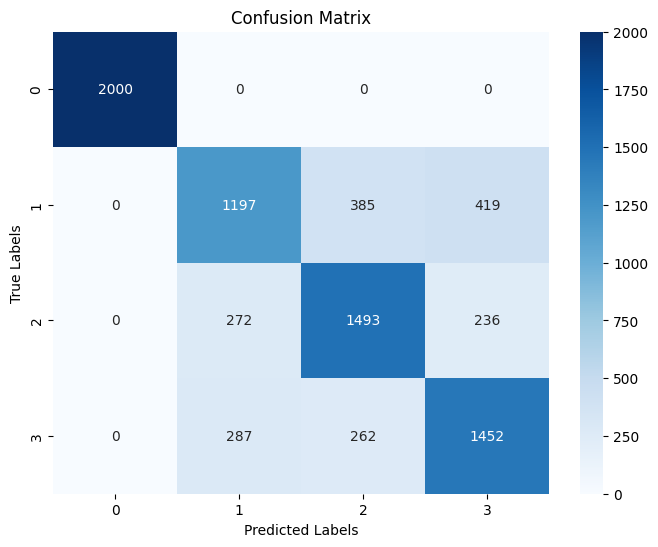

In [14]:
# Convert data to PyTorch tensors
X = torch.tensor(X_smote, dtype=torch.float32)
y = torch.tensor(y_smote, dtype=torch.long)

# Define the number of folds for cross-validation
num_splits = 5  # You can adjust the number of folds as needed

# Initialize lists to store accuracy scores for each fold
fold_accuracies = []
# Initialize lists to store time taken for training and testing
train_times = []
test_times = []

# Initialize lists to store true labels and predicted labels
all_true_labels = []
all_predicted_labels = []

# Initialize the cross-validator
kf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Loop over the folds
for train_index, test_index in kf.split(X, y):
    start_time = time.time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create DataLoader for training and testing
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Define an LSTM model
    class LSTMModel(nn.Module):
        def __init__(self, input_size, lstm_hidden_size, num_lstm_layers, num_classes):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, lstm_hidden_size, num_lstm_layers, batch_first=True)
            self.fc = nn.Linear(lstm_hidden_size, num_classes)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            output = self.fc(lstm_out)
            return output

    # Specify the model hyperparameters
    input_size = 47  # Number of input features
    lstm_hidden_size = 128  # LSTM hidden layer size
    num_lstm_layers = 2  # Number of LSTM layers
    num_classes = len(np.unique(y_train))  # Number of classes

    # Create an instance of the LSTM model
    model = LSTMModel(input_size, lstm_hidden_size, num_lstm_layers, num_classes)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 150
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in tqdm(range(num_epochs), desc=f'Fold {len(fold_accuracies) + 1}/{num_splits}'):
        model.train()
        correct_train = 0
        total_train = 0
        running_train_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Evaluation on the test set
        model.eval()
        correct_test = 0
        total_test = 0
        running_test_loss = 0.0

        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            # Store true and predicted labels for the confusion matrix
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())


        # Calculate time taken for testing this epoch
        test_time_epoch = time.time() - start_time
        test_times.append(test_time_epoch)

        test_accuracy = correct_test / total_test
        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(test_accuracy)

        # Calculate time taken for training this epoch
        train_time_epoch = time.time() - start_time
        train_times.append(train_time_epoch)

    # Store the accuracy of this fold
    fold_accuracies.append(test_accuracies[-1])

    # Calculate and display the confusion matrix
    model.eval()
    all_true_labels = []
    all_predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_true_labels.extend(labels.cpu().numpy())
            all_predicted_labels.extend(predicted.cpu().numpy())

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(fold_accuracies)
print(f'Mean Accuracy: {mean_accuracy * 100:.2f}%')

# Calculate the total test loss across all folds
total_test_loss = sum(test_losses)

# Calculate the total average test loss (across all epochs and folds)
total_average_test_loss = total_test_loss / (num_splits * num_epochs)
# Calculate and print the mean training loss across all epochs and folds
mean_training_loss = np.mean(train_losses)
print(f'Mean Training Loss: {mean_training_loss:.4f}')

# Calculate and print the mean test loss across all epochs and folds
mean_test_loss = np.mean(test_losses)
print(f'Mean Test Loss: {mean_test_loss:.4f}')

# Calculate and print the mean training and testing times
mean_train_time = np.sum(train_times)
mean_test_time = np.sum(test_times)
print(f'Mean Training Time (per epoch): {mean_train_time:.2f} seconds')
print(f'Mean Testing Time (per epoch): {mean_test_time:.2f} seconds')

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_accuracies, label="Train")
plt.plot(range(num_epochs), test_accuracies, label="Test")
plt.title("Accuracy vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/150_epochs_accuracy.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_losses, label="Train")
plt.plot(range(num_epochs), test_losses, label="Test")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/150_epochs_loss.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure to start a new one

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Thesis/MalMem/Classification/graphs/lstm/150_epochs_confusion.pdf', format='pdf')
plt.show()
plt.close()  # Close the figure